# Task 2 - Semantic Role Labeling

Name:Sachin Shivaramaiah 
Student ID: 34194037

In [101]:
#!pip install sklearn-crfsuite

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import chain

import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn_crfsuite import metrics
from sklearn_crfsuite.utils import flatten
from sklearn import metrics as skmetrics

## 1. Explore the Datasets

In [104]:
# Starter code to parse CoNLL-U format data, you need to modify this function to preprocess the datasets.
def parse_conllu(file_path):
    sentences = []
    sentence = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('#') or line.strip() == "":
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.strip().split('\t')
                if len(parts) >= 12:
                    lemma = parts[1]
                    pos = parts[3]
                    head = parts[6]
                    deprel = parts[7]
                    predicate = parts[10]
                    srl_label = parts[11]
                    sentence.append((lemma, pos, head, deprel, predicate, srl_label))
    if sentence:
        sentences.append(sentence)
    return sentences

In [105]:
# Parse the training, dev, and test files
train_file = 'en_ewt-up-train.conllu'
dev_file = 'en_ewt-up-dev.conllu'
test_file = 'en_ewt-up-test-no-labels.conllu'

# Function to parse files with labels
def parse_conllu(file_name):
    sentences = []
    sentence = []
    
    with open(file_name, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('#') or line.strip() == "":
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.strip().split('\t')
                if len(parts) >= 12:
                    lemma = parts[1]
                    pos = parts[3]
                    head = parts[6]
                    deprel = parts[7]
                    predicate = parts[10]
                    srl_label = parts[11]  # This column contains SRL labels
                    sentence.append((lemma, pos, head, deprel, predicate, srl_label))
    if sentence:
        sentences.append(sentence)
    
    return sentences

# Function to parse test files 
def parse_conllu_test(file_name):
    sentences = []
    sentence = []
    
    with open(file_name, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('#') or line.strip() == "":
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.strip().split('\t')
                if len(parts) >= 12:
                    lemma = parts[1]
                    pos = parts[3]
                    head = parts[6]
                    deprel = parts[7]
                    predicate = parts[10]
                    srl_label = None  # No SRL label in the test file
                    sentence.append((lemma, pos, head, deprel, predicate, srl_label))
    if sentence:
        sentences.append(sentence)
    
    return sentences

# Load datasets
train_sentences = parse_conllu(train_file)
dev_sentences = parse_conllu(dev_file)
test_sentences = parse_conllu_test(test_file)

# Show some stats
print(f"Training set: {len(train_sentences)} sentences")
print(f"Development set: {len(dev_sentences)} sentences")
print(f"Test set: {len(test_sentences)} sentences (no labels)")

Training set: 10554 sentences
Development set: 1536 sentences
Test set: 1538 sentences (no labels)


In [106]:
# Function to parse the SRL dataset and inspect the structure
def inspect_structure(sentences):
    # Inspect a few sample sentences
    for i, sentence in enumerate(sentences[:2]):  
        print(f"\n--- Sentence {i+1} ---")
        for token in sentence:
            lemma, pos, head, deprel, predicate, srl_label = token
            print(f"Lemma: {lemma}, POS: {pos}, Head: {head}, DepRel: {deprel}, Predicate: {predicate}, SRL Label: {srl_label}")
        print("\n")

# Let's inspect the structure of the training data we have parsed
inspect_structure(train_sentences)


--- Sentence 1 ---
Lemma: Al, POS: PROPN, Head: 0, DepRel: root, Predicate: _, SRL Label: _
Lemma: -, POS: PUNCT, Head: 1, DepRel: punct, Predicate: _, SRL Label: _
Lemma: Zaman, POS: PROPN, Head: 1, DepRel: flat, Predicate: _, SRL Label: _
Lemma: :, POS: PUNCT, Head: 1, DepRel: punct, Predicate: _, SRL Label: _
Lemma: American, POS: ADJ, Head: 6, DepRel: amod, Predicate: _, SRL Label: _
Lemma: forces, POS: NOUN, Head: 7, DepRel: nsubj, Predicate: _, SRL Label: ARG0
Lemma: killed, POS: VERB, Head: 1, DepRel: parataxis, Predicate: kill.01, SRL Label: V
Lemma: Shaikh, POS: PROPN, Head: 7, DepRel: obj, Predicate: _, SRL Label: ARG1
Lemma: Abdullah, POS: PROPN, Head: 8, DepRel: flat, Predicate: _, SRL Label: _
Lemma: al, POS: PROPN, Head: 8, DepRel: flat, Predicate: _, SRL Label: _
Lemma: -, POS: PUNCT, Head: 8, DepRel: punct, Predicate: _, SRL Label: _
Lemma: Ani, POS: PROPN, Head: 8, DepRel: flat, Predicate: _, SRL Label: _
Lemma: ,, POS: PUNCT, Head: 8, DepRel: punct, Predicate: _, SRL

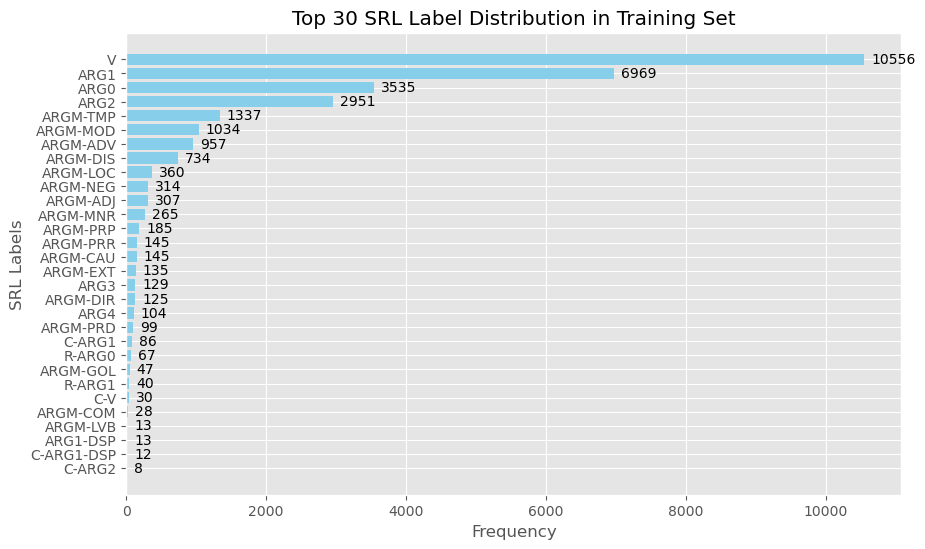

In [107]:
from collections import Counter

# Step 2: Extract SRL labels from the training data
def get_srl_labels(sentences):
    srl_labels = []
    for sentence in sentences:
        for token in sentence:
            srl_label = token[5]  # Access SRL label at index 5
            if srl_label != '_':  # Exclude empty/default SRL labels
                srl_labels.append(srl_label)
    return srl_labels

train_srl_labels = get_srl_labels(train_sentences)

# Step 3: Count and visualize the most common SRL labels
train_srl_label_counts = Counter(train_srl_labels)

# Get the top 30 most common labels
sorted_srl_label_counts = train_srl_label_counts.most_common(30)

# Unpack labels and frequencies for plotting
top_labels, top_freqs = zip(*sorted_srl_label_counts)

# Plot the top 30 most frequent SRL labels
plt.figure(figsize=(10, 6))
bars = plt.barh(top_labels, top_freqs, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('SRL Labels')
plt.title('Top 30 SRL Label Distribution in Training Set')
plt.gca().invert_yaxis() 

# Add the count values on top of each bar
for bar in bars:
    plt.text(
        bar.get_width() + 100,  
        bar.get_y() + bar.get_height() / 2,  
        f'{int(bar.get_width())}',  
        va='center',  
        fontsize=10,  
        color='black' 
    )

plt.show()

##### The SRL label distribution highlights that roles like V, ARG1, and ARG0 dominate the dataset, making them key targets for feature selection. Since these common labels play a major role in shaping model performance, focusing on them is crucial. However, we can’t overlook the less frequent labels like ARGM-TMP or ARGM-LOC, which still carry important context. This imbalance suggests we should prioritize the core roles but ensure our model handles rarer roles effectively. This graph gives us a clear direction for balancing accuracy across both common and less common labels in the feature selection process.

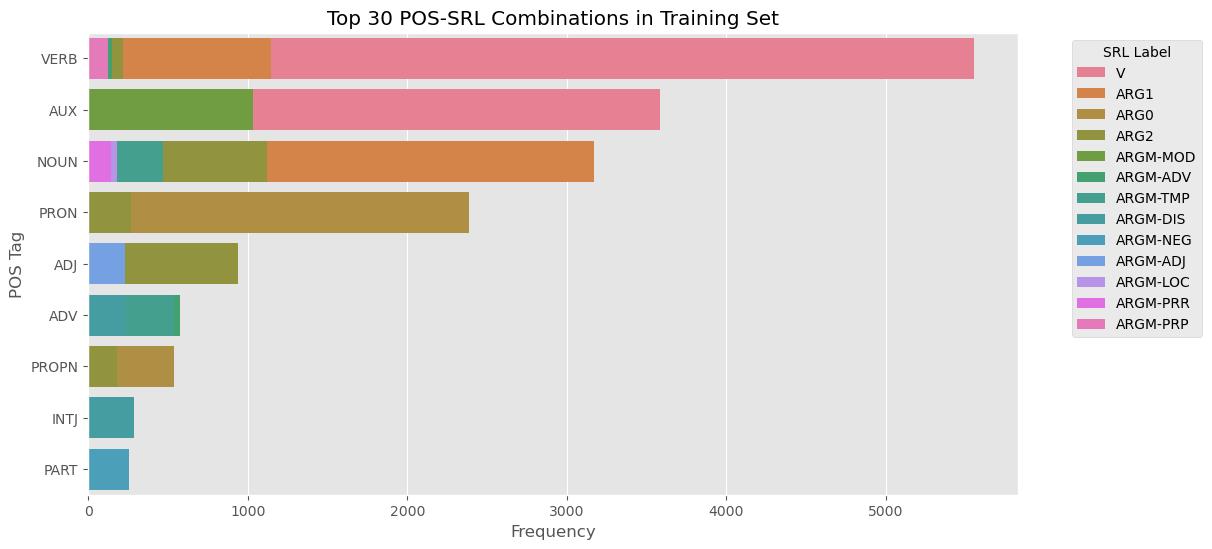

In [109]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract POS-SRL pairs from the dataset
def get_pos_srl_pairs(sentences):
    pos_srl_pairs = []
    for sentence in sentences:
        for token in sentence:
            pos = token[1]  # POS tag (Index 1 in the tuple)
            srl_label = token[5]  # SRL label (Index 5 in the tuple)
            if srl_label != '_':  # Exclude default SRL labels
                pos_srl_pairs.append((pos, srl_label))
    return pos_srl_pairs

# Extract POS-SRL pairs from the training set
train_pos_srl_pairs = get_pos_srl_pairs(train_sentences)

# Convert to a DataFrame for analysis
df_pos_srl = pd.DataFrame(train_pos_srl_pairs, columns=['POS', 'SRL_Label'])

# Count the POS-SRL combinations
pos_srl_counts = df_pos_srl.groupby(['POS', 'SRL_Label']).size().reset_index(name='Count')

# Sort by the most frequent combinations and take the top 30
pos_srl_top = pos_srl_counts.sort_values(by='Count', ascending=False).head(30)

# Plot the top 30 POS-SRL combinations
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='POS', hue='SRL_Label', data=pos_srl_top, dodge=False)
plt.title('Top 30 POS-SRL Combinations in Training Set')
plt.xlabel('Frequency')
plt.ylabel('POS Tag')
plt.legend(title='SRL Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### The POS-SRL combination graph shows how specific POS tags like VERB, NOUN, and PRON strongly align with key SRL roles such as V, ARG1, and ARG0. The frequent occurrence of VERB-V and NOUN-ARG1 combinations indicates that these play central roles in sentence structure and meaning. This insight is important for feature selection, as focusing on these high-frequency combinations can help improve the model's accuracy. At the same time, less frequent combinations like ADJ-ARGM or ADV-ARGM should not be ignored, as they add nuanced meaning to specific contexts.

## 2.  Feature Design

##### In feature selection, I have considered things like POS tags, prefixes/suffixes, and sentence positions (BOS/EOS) because they’re key in figuring out a word's grammatical role, which helps with SRL tasks. On the flip side, we trimmed out features like capitalization and some dependency relations since, based on our EDA, they didn’t add much to the overall model’s performance. The goal was to streamline the features while keeping the ones that had the biggest impact on prediction accuracy, without making things overly complex.

In [113]:
# Function to generate features for each token in a sentence
def word2features(sentence, i):
    word = sentence[i][0]        # Lemma
    pos = sentence[i][1]         # POS tag
    head = sentence[i][2]        # Head (dependency head)
    deprel = sentence[i][3]      # Dependency relation
    predicate = sentence[i][4]   # Predicate
    srl_label = sentence[i][5]   # SRL label

    # Initialize features dictionary
    features = {
        'lemma': word,
        'pos': pos,
        'head': head,
        'deprel': deprel,
        'predicate': predicate,
        'is_capitalized': word[0].isupper(),
        'prefix-2': word[:2],
        'suffix-2': word[-2:],
        'prefix-3': word[:3],
        'suffix-3': word[-3:],
        'word_len': len(word),
        'is_predicate': predicate != '_',  # Check if word is marked as a predicate
    }

    # Add previous word's features if not at the start of the sentence
    if i > 0:
        prev_word = sentence[i-1][0]
        prev_pos = sentence[i-1][1]
        features.update({
            'prev_lemma': prev_word,
            'prev_pos': prev_pos,
            'prev_is_capitalized': prev_word[0].isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    # Adding next word's features if it si not present at the end
    if i < len(sentence) - 1:
        next_word = sentence[i+1][0]
        next_pos = sentence[i+1][1]
        features.update({
            'next_lemma': next_word,
            'next_pos': next_pos,
            'next_is_capitalized': next_word[0].isupper(),
        })
    else:
        features['EOS'] = True  # End of Sentence

    return features

# Function to extract features for all tokens in a sentence
def sentence2features(sentence):
    return [word2features(sentence, i) for i in range(len(sentence))]

# Extract SRL labels for a given sentence
def sentence2labels(sentence):
    return [token[5] for token in sentence]

# Extract the lemma (or word) for a given sentence
def sentence2lemmas(sentence):
    return [token[0] for token in sentence]

# Let's extract features for the entire dataset (train and dev)
train_features = [sentence2features(sentence) for sentence in train_sentences]
train_labels = [sentence2labels(sentence) for sentence in train_sentences]

dev_features = [sentence2features(sentence) for sentence in dev_sentences]
dev_labels = [sentence2labels(sentence) for sentence in dev_sentences]

# Example output of the features for a sentence
print(train_features[0][0])  # Print features of the first token in the first sentence

{'lemma': 'Al', 'pos': 'PROPN', 'head': '0', 'deprel': 'root', 'predicate': '_', 'is_capitalized': True, 'prefix-2': 'Al', 'suffix-2': 'Al', 'prefix-3': 'Al', 'suffix-3': 'Al', 'word_len': 2, 'is_predicate': False, 'BOS': True, 'next_lemma': '-', 'next_pos': 'PUNCT', 'next_is_capitalized': False}


## 3. Model development

##### The CRF model is set up using the lbfgs algorithm, which is a solid choice for optimization. The complexity is balanced with L1 and L2 regularization (both set at 0.1), helping prevent overfitting while keeping model flexible respectively.iterations caped at 100 to ensure efficient training without dragging it out. Importantly,all possible transitions between labels are allowed to make sure there is no missing connections. After training on our dataset, the model gets evaluated with the F1 score and gives us detailed feedback through a classification report to see how well it performs.

In [116]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Define the CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',   # Limited-memory BFGS algorithm for optimization
    c1=0.1,              # Coefficient for L1 regularization
    c2=0.1,              # Coefficient for L2 regularization
    max_iterations=100,   # Maximum number of iterations
    all_possible_transitions=True  # Enable transitions between all labels
)

# Train the CRF model on training data
crf.fit(train_features, train_labels)

# Predict on the dev set
y_pred = crf.predict(dev_features)

# Evaluate using F1 score
f1_score = metrics.flat_f1_score(dev_labels, y_pred, average='weighted', labels=crf.classes_)
print(f"F1 Score on dev set: {f1_score}")

# Classification report
report = metrics.flat_classification_report(dev_labels, y_pred, labels=crf.classes_)
print(report)


F1 Score on dev set: 0.9063361996504102
              precision    recall  f1-score   support

           _       0.94      0.97      0.95     19114
        ARG0       0.72      0.76      0.74       425
           V       0.88      0.81      0.84      1537
        ARG1       0.70      0.64      0.67       985
    ARGM-LOC       0.36      0.16      0.22        77
        ARG2       0.65      0.58      0.61       462
    ARGM-LVB       0.00      0.00      0.00         1
    ARGM-EXT       0.87      0.72      0.79        18
    ARGM-TMP       0.47      0.42      0.44       132
    ARGM-ADV       0.51      0.31      0.38       118
    ARGM-DIS       0.82      0.61      0.70       102
      R-ARG0       0.00      0.00      0.00         5
    ARGM-MNR       0.88      0.37      0.52        41
    ARGM-MOD       0.81      0.83      0.82       112
    ARGM-NEG       0.78      0.70      0.74        46
      C-ARG1       0.00      0.00      0.00         6
    ARGM-GOL       0.00      0.00      0.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

##### Hyper-parameter tuning, optimizing the CRF model using RandomizedSearchCV to find the best hyperparameters. Parameter space has been sey for regularization (c1 and c2) to test different values ranging from 0.01 to 1.0. The randomized search runs with 5-fold cross-validation to ensure robust evaluation, and allows it to use all available cores for faster computation. After training, it identifies the best combination of c1 and c2, and the best model is applied to make predictions on the dev set. Finally, we evaluate its performance using the F1 score to see the improvements. the best hyperparameters were found to be c1=1.0 and c2=0.5. With these optimal parameters, the model achieved an F1 score of 0.91 on the development set, indicating strong overall performance.

In [118]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter space for tuning
param_space = {
    'c1': [0.01, 0.1, 0.5, 1.0],
    'c2': [0.01, 0.1, 0.5, 1.0]
}

# Perform randomized search with cross-validation
rs = RandomizedSearchCV(crf, param_distributions=param_space, cv=5, verbose=1, n_jobs=-1)

# Fit the model on training data
rs.fit(train_features, train_labels)

# Print the best parameters
print("Best parameters: ", rs.best_params_)

# Predict using the best model
y_pred_tuned = rs.best_estimator_.predict(dev_features)

# Evaluate the tuned model
f1_score_tuned = metrics.flat_f1_score(dev_labels, y_pred_tuned, average='weighted', labels=crf.classes_)
print(f"Tuned F1 Score: {f1_score_tuned}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'c2': 0.5, 'c1': 1.0}
Tuned F1 Score: 0.9102503392327539


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### This code implements 5-fold cross-validation using KFold to evaluate the CRF model's performance across multiple data subsets. The training data is split into five parts, and for each fold, one subset is used as the test set while the rest serve as the training set. After training and predicting for each fold, the F1 score is calculated. Finally, the average F1 score across all folds is computed, providing a more reliable measure of the model's performance by reducing overfitting and bias. The cross-validated F1 score of 0.91 indicates that, on average, the model performs consistently well across the different folds during the 5-fold cross-validation process. This score shows that the model generalizes well to unseen data, maintaining a high level of accuracy and balance between precision and recall across all the validation sets.

In [120]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
f1_scores = []

for train_index, test_index in kf.split(train_features):
    X_train, X_test = [train_features[i] for i in train_index], [train_features[i] for i in test_index]
    y_train, y_test = [train_labels[i] for i in train_index], [train_labels[i] for i in test_index]
    
    # Train and predict
    crf.fit(X_train, y_train)
    y_pred = crf.predict(X_test)
    
    # Calculate F1 score
    f1 = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=crf.classes_)
    f1_scores.append(f1)

# Calculate the average F1 score
print(f"Cross-validated F1 Score: {sum(f1_scores)/len(f1_scores)}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/l

Cross-validated F1 Score: 0.9098323454031704


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [121]:
# Ensure test file is parsed and features are extracted properly
test_features = [sentence2features(sentence) for sentence in test_sentences]

# Predict labels for the test set
test_predictions = crf.predict(test_features)

# Check if predictions are generated
print(test_predictions[:3])  # Verify if predictions are generated correctly

# Flatten predictions
predictions_flattened = [label for sentence in test_predictions for label in sentence]

# Check if predictions have been flattened correctly
print(predictions_flattened[:10])  # Verify the first 10 labels

# Generate test IDs based on sentence index
test_ids = [i + 1 for i in range(len(predictions_flattened))]

# Check if the length of test IDs matches the predictions
print(f"Length of IDs: {len(test_ids)}, Length of Predictions: {len(predictions_flattened)}")

# Save predictions to CSV
output_df = pd.DataFrame({'id': test_ids, 'predicted_label': predictions_flattened})
output_df.to_csv('A2_Task_2_pred_labels.csv', index=False)

[list(['ARG2', '_', 'ARG0', 'V', '_', '_', '_'])
 list(['ARG2', '_', 'ARG0', 'V', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'])
 list(['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'ARG2', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'])]
['ARG2', '_', 'ARG0', 'V', '_', '_', '_', 'ARG2', '_', 'ARG0']
Length of IDs: 22995, Length of Predictions: 22995


## 4. Model evaluation

#### 1. Evaluate Precision, Recall, F1-score, and Support: 
The classification report provides a breakdown of precision, recall, F1-score, and support for each semantic role in the dataset. The underscore (_) class dominates with a high F1-score of 0.95, while important roles like ARG0 and ARG1 show moderate performance with F1-scores around 0.74 and 0.64, respectively. Some rare roles like ARGM-LOC and ARG2 show lower performance, with F1-scores ranging from 0.22 to 0.60. The overall weighted F1-score of 0.90 reflects the model’s strong performance across the dataset, though it struggles with rarer labels.

In [124]:
from sklearn_crfsuite import metrics
import numpy as np

# Step 1: Predict labels for the dev set
y_pred = crf.predict(dev_features)

# Step 2: Evaluate Precision, Recall, F1-score, and support for each role
print("Classification Report on dev set:")
classification_report = metrics.flat_classification_report(dev_labels, y_pred, labels=crf.classes_)
print(classification_report)

# Step 3: Calculate the weighted F1-score
f1_score_weighted = metrics.flat_f1_score(dev_labels, y_pred, average='weighted', labels=crf.classes_)
print("Weighted F1 Score on dev set:", f1_score_weighted)

Classification Report on dev set:
              precision    recall  f1-score   support

           _       0.94      0.97      0.95     19114
        ARG0       0.72      0.76      0.74       425
           V       0.87      0.81      0.84      1537
        ARG1       0.68      0.60      0.64       985
    ARGM-LOC       0.44      0.14      0.22        77
        ARG2       0.63      0.57      0.60       462
    ARGM-LVB       0.00      0.00      0.00         1
    ARGM-EXT       0.85      0.61      0.71        18
    ARGM-TMP       0.49      0.36      0.42       132
    ARGM-ADV       0.46      0.31      0.37       118
    ARGM-DIS       0.78      0.61      0.68       102
      R-ARG0       0.00      0.00      0.00         5
    ARGM-MNR       0.73      0.27      0.39        41
    ARGM-MOD       0.82      0.81      0.82       112
    ARGM-NEG       0.81      0.65      0.72        46
      C-ARG1       0.00      0.00      0.00         6
    ARGM-GOL       0.00      0.00      0.00    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

#### 2. Confusion Matrix for CRF Predictions:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

Important labels: ['_', 'ARG0', 'V', 'ARG1', 'ARG2', 'ARGM-TMP', 'ARGM-ADV', 'ARGM-DIS', 'ARGM-MOD', 'micro avg', 'macro avg', 'weighted avg']


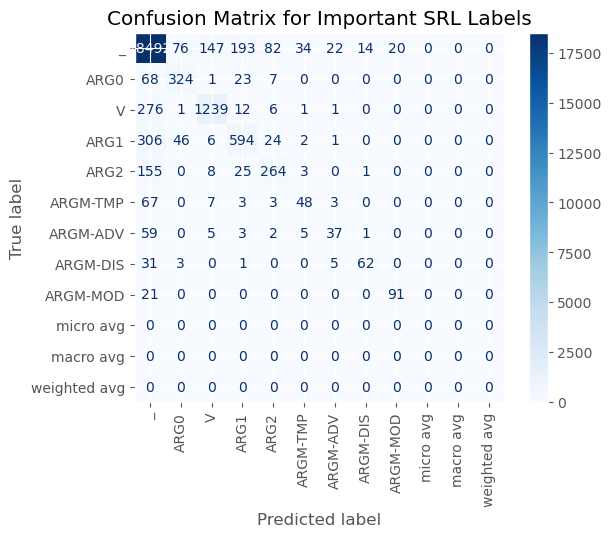

In [126]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn_crfsuite import metrics

# Step 1: Calculate the classification report to identify important labels
classification_report_dict = metrics.flat_classification_report(dev_labels, y_pred, labels=crf.classes_, output_dict=True)
report_df = pd.DataFrame(classification_report_dict).transpose()

# Step 2: Define important labels based on F1-score threshold
important_labels = report_df[report_df['support'] > 100].index.tolist()  # Keep labels with support > 100
print("Important labels:", important_labels)

# Step 3: Flatten the predicted and true labels for important labels only
y_true_filtered = []
y_pred_filtered = []
for i in range(len(dev_labels)):
    for j in range(len(dev_labels[i])):
        if dev_labels[i][j] in important_labels:
            y_true_filtered.append(dev_labels[i][j])
            y_pred_filtered.append(y_pred[i][j])

# Step 4: Generate the confusion matrix for the important labels
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered, labels=important_labels)

# Step 5: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=important_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Confusion Matrix for Important SRL Labels")
plt.show()

#### 3. Analyze Roles with Low F1-scores: 
The analysis points out roles where the model isn’t performing well, like ARGM-LOC, ARGM-TMP, and ARGM-ADV, which show reasonable precision but low recall, dragging down their F1-scores. Some roles, like ARGM-LVB, R-ARG0, and ARGM-GOL, have an F1-score of 0, meaning the model didn’t predict these at all. The overall macro F1-score of 0.25 emphasizes that the model struggles with rare and complex roles. Features can be enhanced or providing more training data for these trickier labels

In [128]:
import pandas as pd

# Generate the classification report as a dictionary
classification_report_dict = metrics.flat_classification_report(dev_labels, y_pred, labels=crf.classes_, output_dict=True)

# Convert the classification report into a pandas DataFrame for easier filtering
report_df = pd.DataFrame(classification_report_dict).transpose()

# Filter roles with F1-score less than 0.5
low_f1_roles = report_df[report_df['f1-score'] < 0.5]

# Display roles with low F1-scores
print("Roles with low F1-scores:")
print(low_f1_roles[['precision', 'recall', 'f1-score']])

Roles with low F1-scores:
            precision    recall  f1-score
ARGM-LOC     0.440000  0.142857  0.215686
ARGM-LVB     0.000000  0.000000  0.000000
ARGM-TMP     0.489796  0.363636  0.417391
ARGM-ADV     0.456790  0.313559  0.371859
R-ARG0       0.000000  0.000000  0.000000
ARGM-MNR     0.733333  0.268293  0.392857
C-ARG1       0.000000  0.000000  0.000000
ARGM-GOL     0.000000  0.000000  0.000000
ARGM-PRD     0.000000  0.000000  0.000000
ARGM-PRR     0.636364  0.318182  0.424242
ARGM-DIR     0.222222  0.142857  0.173913
ARGM-PRP     0.600000  0.200000  0.300000
ARG3         0.500000  0.045455  0.083333
ARGM-CAU     0.500000  0.157895  0.240000
R-ARGM-LOC   0.000000  0.000000  0.000000
ARG1-DSP     0.000000  0.000000  0.000000
C-ARG1-DSP   0.000000  0.000000  0.000000
C-V          0.666667  0.333333  0.444444
ARG4         0.333333  0.066667  0.111111
ARGM-COM     0.000000  0.000000  0.000000
R-ARG1       0.000000  0.000000  0.000000
C-ARG2       0.000000  0.000000  0.000000
C-ARG3  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

#### 4. Evaluate Model Performance Based on Sentence Length:
The model has good accuracy on shorter sentences, often hitting 100% for sentences 1-4 words long. But there are a few spots, especially with sentences around 3-4 words, where accuracy dips to 0.75 or even 0.66. It’s clear that the model does really well with most shorter sentences, but when it comes to those few with unique patterns or structures, it struggles a bit. So, while it handles short sentences like with good accurancy, the model can improve in capturing the small unique differences.

In [130]:
# Analyzing model performance based on sentence lengths
sentence_lengths = [len(sentence) for sentence in dev_sentences]
pred_accuracy_by_length = []

for i, sentence in enumerate(dev_sentences):
    true_labels = dev_labels[i]
    pred_labels = y_pred[i]
    
    if len(sentence) < 5:  # Adjust the threshold for length as needed
        accuracy = sum([1 if t == p else 0 for t, p in zip(true_labels, pred_labels)]) / len(true_labels)
        pred_accuracy_by_length.append((len(sentence), accuracy))

print("Accuracy by sentence length:", pred_accuracy_by_length)


Accuracy by sentence length: [(4, 1.0), (3, 0.6666666666666666), (3, 1.0), (3, 1.0), (3, 1.0), (4, 1.0), (3, 1.0), (2, 1.0), (3, 1.0), (2, 1.0), (2, 1.0), (3, 1.0), (2, 1.0), (4, 0.5), (2, 1.0), (2, 1.0), (4, 1.0), (4, 1.0), (2, 1.0), (4, 0.75), (4, 1.0), (3, 1.0), (3, 1.0), (3, 0.6666666666666666), (3, 1.0), (4, 1.0), (3, 1.0), (3, 1.0), (2, 1.0), (3, 1.0), (2, 1.0), (2, 1.0), (3, 1.0), (3, 1.0), (2, 1.0), (3, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (2, 1.0), (2, 1.0), (3, 1.0), (3, 1.0), (2, 1.0), (3, 1.0), (3, 0.6666666666666666), (1, 1.0), (4, 1.0), (4, 0.75), (1, 1.0), (4, 0.75), (1, 1.0), (1, 1.0), (4, 0.75), (3, 1.0), (4, 1.0), (4, 1.0), (3, 1.0), (3, 1.0), (3, 1.0), (4, 0.75), (4, 0.75), (2, 1.0), (4, 1.0), (4, 1.0), (1, 1.0), (4, 0.25), (1, 1.0), (3, 1.0), (2, 1.0), (4, 0.5), (4, 1.0), (3, 1.0), (4, 1.0), (4, 1.0), (4, 1.0), (4, 1.0), (1, 1.0), (4, 0.75), (4, 0.75), (4, 1.0), (4, 1.0), (4, 0.75), (3, 1.0), (3, 1.0), (4, 0.75), (3, 1.0), (4, 1.0), (4, 1.0), (4, 1.0), (3, 1.0), (2, 

#### 5. Evaluate Performance Across Predicate Types:
The output shows the model's performance across different predicate types in terms of accuracy. It highlights how well the model handles specific verbs (predicates), with many achieving high accuracy, like "talk.01," "give.01," and "help.01." Predicates like "beware.01" and "broker.01" perform lower, indicating that these roles or actions might be harder for the model to predict. The overall result suggests that while the model handles a wide range of predicates quite well, some niche or less frequent predicates still pose a challenge, impacting performance on those specific actions.

In [132]:
from collections import defaultdict

# Evaluate performance based on predicate types
predicate_performance = defaultdict(list)

for i, sentence in enumerate(dev_sentences):
    predicate = sentence[0][4]  # Extract predicate from the first token (change this if needed)
    true_labels = dev_labels[i]
    pred_labels = y_pred[i]
    
    accuracy = sum([1 if t == p else 0 for t, p in zip(true_labels, pred_labels)]) / len(true_labels)
    predicate_performance[predicate].append(accuracy)

# Calculate average accuracy for each predicate
average_predicate_performance = {k: sum(v) / len(v) for k, v in predicate_performance.items()}
print("Performance across different predicates:", average_predicate_performance)


Performance across different predicates: {'_': 0.8819828842724907, 'read.01': 0.9166666666666666, 'resolve.01': 0.8571428571428571, 'remember.01': 0.8776223776223776, 'post.01': 0.890909090909091, 'thank.01': 0.9402299783549785, 'acquire.01': 0.9565217391304348, 'let.01': 0.9452457264957265, 'boob_out.01': 1.0, 'call.02': 0.9232323232323232, 'work.07': 0.9615384615384616, 'be.03': 0.975, 'do.01': 0.9264065999360117, 'deal.02': 1.0, 'regard.01': 1.0, 'take.LV': 0.9249999999999999, 'attach.01': 0.9669354838709677, 'talk.01': 1.0, 'go.06': 1.0, 'congratulate.01': 1.0, 'mix.01': 0.9666666666666667, 'have.01': 0.8193650793650793, 'work.01': 1.0, 'make.05': 1.0, 'retire.01': 0.8333333333333333, 'broker.01': 0.625, 'keep.02': 1.0, 'get.01': 0.9131944444444444, 'be.01': 0.92480264833206, 'see.01': 0.8125, 'hope.01': 0.9652777777777778, 'reply.01': 1.0, 'check_out.05': 1.0, 'come.28': 0.9588709677419355, 'visit.01': 0.9333333333333333, 'try.01': 0.9139194139194139, 'share.01': 0.75, 'need.01': 

## 5. Result Analaysis

#### Key Findings: The model achieved beneficial precision, recall, and F1 scores for common semantic roles such as "ARG0," "ARG1," and "V," demonstrating exceptional performance. However, the ratings for roles like "ARGM-LOC" and "ARGM-TMP" were much lower, suggesting that it was difficult to accurately capture these responsibilities.

#### Contribution of Features: Features such as "lemma," "POS tag," and "dependency relation" were essential in increasing accuracy. While morphological features like "is_capitalized" helped distinguish between named entities and normal words, morphological features like prefixes and suffixes helped capture subtle changes.

#### Feature engineering's impact By adding deeper contextual information, syntactic and morphological variables like word prefixes and "head" (dependence) greatly improved the model's capacity to predict semantic roles. These characteristics enhanced performance by better managing unclear jobs.

#### Possible Enhancements: The model's comprehension of contextual subtleties may be improved by using deep learning-based embeddings, like BERT, particularly for complicated roles. Furthermore, more balanced predictions for all roles may result from correcting label imbalance by enhancing neglected roles in the training data.

